## This notebook simulates a flock of birds using the Boid model with the addition of food source.

#### create the dataset in pytorch format
Positions: (rollout steps ahead, number of boids, 2)
ex: (100 frames, 20 boids, 2 dimensions)

Species: a list of num_boid entries of each boid’s identity, (number of boids)
ex: ['goose', 'goose', 'crane', 'crane', 'crane']

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

import matplotlib.pyplot as plt
import torch
from torch_geometric.data import DataLoader

from collab_env.data.file_utils import expand_path, get_project_root

# our code
from collab_env.sim.boids_gnn_temp.animal_simulation import (
    AnimalTrajectoryDataset,
    visualize_graph,
)
from collab_env.sim.boids_gnn_temp.boid import (
    init_multi_species_boids,
    update_boids_with_food,
)

# %%


smoke_test = "CI" in os.environ
save_file = True

steps = 1200 if not smoke_test else 10
num_samples = 1000

In [7]:
width = 480
height = 480
independent = False

food_config = {"x": width / 3, "y": 0, "counts": 1}
species_configs = {  # different spieces should have a different set of values for all the parameters
    # but the parameter name should all be the same for one updating algorithms.
    "A": {
        "visual_range": 60,
        "centering_factor": 0.005,
        "min_distance": 15,
        "avoid_factor": 0.05,
        "matching_factor": 0.5,  # 0.1, 0.5
        "margin": 20,  # 0.05, 25
        "turn_factor": 4,
        "speed_limit": 7,
        "food_factor": 0.05,  # 0.15, #0.05
        "food_visual_range": 200,
        "food_eating_range": 20,
        "food_time": 300,
        "hunger_threshold": -100,
        "counts": 20,
        "width": width,
        "height": height,
        "independent": independent,
        "food": food_config,
    },  # the food that species A can see
    "food0": food_config,
}

dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids_with_food,
    species_configs,
    width=width,
    height=height,
    steps=steps,
    num_samples=num_samples,
    seed=2025,
)

file_name = "boid_food_basic.pt"
config_name = "boid_food_basic_config.pt"

if save_file:
    torch.save(dataset, expand_path("simulated_data/" + file_name, get_project_root()))
    torch.save(
        species_configs,
        expand_path("simulated_data/" + config_name, get_project_root()),
    )

### independent with food

In [8]:
width = 480
height = 480
independent = True

food_config = {"x": width / 3, "y": 0, "counts": 1}
species_configs = {  # different spieces should have a different set of values for all the parameters
    # but the parameter name should all be the same for one updating algorithms.
    "A": {
        "visual_range": 60,
        "centering_factor": 0.005,
        "min_distance": 15,
        "avoid_factor": 0.05,
        "matching_factor": 0.5,  # 0.1, 0.5
        "margin": 20,  # 0.05, 25
        "turn_factor": 4,
        "speed_limit": 7,
        "food_factor": 0.05,
        "food_visual_range": 200,
        "food_eating_range": 20,
        "food_time": 300,
        "hunger_threshold": -100,
        "counts": 20,
        "width": width,
        "height": height,
        "independent": independent,
        "food": food_config,
    },  # the food that species A can see
    "food0": food_config,
}

dataset = AnimalTrajectoryDataset(
    init_multi_species_boids,
    update_boids_with_food,
    species_configs,
    width=width,
    height=height,
    steps=steps,
    num_samples=num_samples,
    seed=2025,
)

file_name = "boid_food_basic_independent.pt"
config_name = "boid_food_basic_independent_config.pt"

if save_file:
    torch.save(dataset, expand_path("simulated_data/" + file_name, get_project_root()))
    torch.save(
        species_configs,
        expand_path("simulated_data/" + config_name, get_project_root()),
    )

### Visualize boids

In [10]:
# file_name = 'boid_food_basic_alignment.pt'
# config_name = 'boid_food_basic_alignment_config.pt'
file_name = "boid_food_basic.pt"
config_name = "boid_food_basic_config.pt"


dataset = torch.load(
    expand_path("simulated_data/" + file_name, get_project_root()),
    weights_only=False,
)
species_configs = torch.load(
    expand_path("simulated_data/" + config_name, get_project_root()),
    weights_only=False,
)

In [11]:
batch_size = 1
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

batch = next(iter(loader))
p, species = batch

print("made", str(len(list(loader))), "batches, each of size", str(batch_size))  #
print("Positions:", p.shape)  # [B, steps, N, 2]
print("Species labels:", species.shape)  # [B, N]
print("\n")

made 1000 batches, each of size 1
Positions: torch.Size([1, 1200, 21, 2])
Species labels: torch.Size([1, 21])




/Users/dima/git/collab-environment/.venv-310/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


p0 shape torch.Size([21, 2])
p shape torch.Size([1199, 21, 2])


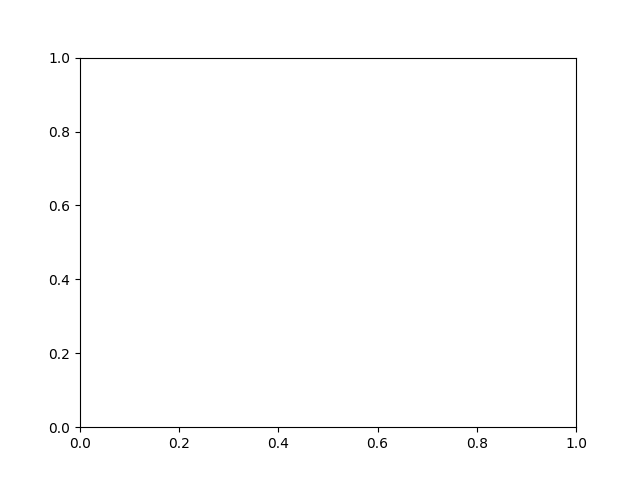

In [17]:
%matplotlib widget
global ani

file_id = 7
batch = list(iter(loader))[file_id]
p, species = batch
v = torch.diff(p, dim=1)

_, F, _2, dim = p.shape
starting_frame = int(round(3 * F / 4))
ani, _ = visualize_graph(
    p[0, 1:],
    v[0],
    # species=species,
    batch=None,
    starting_frame=0,
    file_id=0,
    # ending_frame=1000,
)

In [18]:
file_name = "boid_food_basic_independent.pt"
if save_file:
    ani.save(f"boid_food_basic_alignment{file_id}.gif", writer="pillow", fps=20)

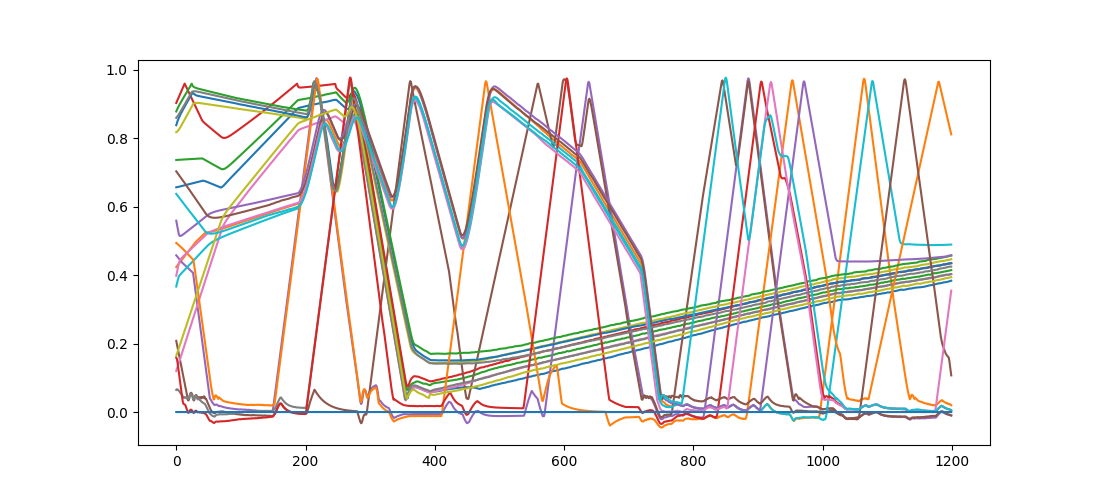

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(11, 5))
for b_ind in range(21):
    axes.plot(p[0, :, b_ind, 1])